# Estudo para redução de churn em Telecomunicações

O objetivo desse estudo é avaliar o cenário de churn elevado dos clientes de uma empresa de telecomunicalções. O produto
possui custo elevado de setup (instalação) e, portanto, a empresa gostaria de uma estratégia para reduzir esse churn.

### Parte 1: Análise descritiva


Importando as bibliotecas necessárias para a análise.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from unidecode import unidecode
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.util import mark_negation
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer

Salvando os pacotes para trabalhar com textos em português.

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')

stop_words = set(stopwords.words('portuguese'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\uni30187\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\uni30187\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\uni30187\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\uni30187\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Lendo o conjunto de dados e visualizando uma amostra dos dados.

In [3]:
df = pd.read_csv("churn_com_texto.csv",delimiter=",", quotechar='"', on_bad_lines="skip")
df.head()

,ID,Nome,Idade,Gênero,Localização,Estado Civil,Número de Dependentes,Data de Início do Contrato,Data de Término do Contrato,Valor Mensal do Contrato,Tipo de Serviço,Duração Média das Chamadas,Volume de Dados,Número de Reclamações,Comentários
0,1,João Silva,35,Masculino,São Paulo/SP/São Paulo,Casado,2,2018-05-10,NaN,79.99,Telefonia Móvel,4.5,2.3 GB,2,O serviço de internet tem sido instável. Estou...
1,2,Maria Santos,28,Feminino,Rio de Janeiro/RJ/Rio de Janeiro,Solteiro,0,2019-03-15,NaN,109.99,Internet,NaN,-,0,Estou satisfeita com o serviço. A velocidade d...
2,3,Carlos Oliveira,42,Masculino,Belo Horizonte/MG/Minas Gerais,Casado,1,2020-01-20,2021-06-30,139.99,Internet,NaN,-,1,Tive problemas com a fatura deste mês. O valor...
3,4,Ana Pereira,55,Feminino,Porto Alegre/RS/Rio Grande do Sul,Viúvo,0,2017-09-01,NaN,159.99,Telefonia Fixa,6.2,NaN,-,Sem reclamações até o momento. O serviço tem a...
4,5,Paulo Rodrigues,41,Masculino,Brasília/DF,Divorciado,3,2019-11-12,2022-01-05,99.99,TV a Cabo,NaN,-,0,O canal de esportes não está funcionando corre...


Pela amostra acima, conseguimos identificar features importantes que são recomendadas em análises de churn, como características do contrato de serviços, tempo de contrato, reclamações e comentários. Algumas informações sensíveis como idade, localização, gênero e número de dependentes também auxiliam a traçar o perfil (persona) dos contratantes de cada tipo de serviço oferecido.

Antes de iniciar as análises, vamos realizar um tratamento para os valores nulos e não preenchidos.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           100 non-null    int64  
 1   Nome                         100 non-null    object 
 2   Idade                        100 non-null    int64  
 3   Gênero                       100 non-null    object 
 4   Localização                  100 non-null    object 
 5   Estado Civil                 100 non-null    object 
 6   Número de Dependentes        100 non-null    int64  
 7   Data de Início do Contrato   100 non-null    object 
 8   Data de Término do Contrato  4 non-null      object 
 9   Valor Mensal do Contrato     100 non-null    float64
 10  Tipo de Serviço              100 non-null    object 
 11  Duração Média das Chamadas   61 non-null     float64
 12  Volume de Dados              85 non-null     object 
 13  Número de Reclamações

In [5]:
df['Número de Reclamações'] = pd.to_numeric(df['Número de Reclamações'], errors='coerce')
df = df.fillna(0)
df = df.replace('-','0')
df['Comentários'] = df['Comentários'].astype(str, errors='ignore')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           100 non-null    int64  
 1   Nome                         100 non-null    object 
 2   Idade                        100 non-null    int64  
 3   Gênero                       100 non-null    object 
 4   Localização                  100 non-null    object 
 5   Estado Civil                 100 non-null    object 
 6   Número de Dependentes        100 non-null    int64  
 7   Data de Início do Contrato   100 non-null    object 
 8   Data de Término do Contrato  100 non-null    object 
 9   Valor Mensal do Contrato     100 non-null    float64
 10  Tipo de Serviço              100 non-null    object 
 11  Duração Média das Chamadas   100 non-null    float64
 12  Volume de Dados              100 non-null    object 
 13  Número de Reclamações

In [7]:
df.head()

,ID,Nome,Idade,Gênero,Localização,Estado Civil,Número de Dependentes,Data de Início do Contrato,Data de Término do Contrato,Valor Mensal do Contrato,Tipo de Serviço,Duração Média das Chamadas,Volume de Dados,Número de Reclamações,Comentários
0,1,João Silva,35,Masculino,São Paulo/SP/São Paulo,Casado,2,2018-05-10,0,79.99,Telefonia Móvel,4.5,2.3 GB,2.0,O serviço de internet tem sido instável. Estou...
1,2,Maria Santos,28,Feminino,Rio de Janeiro/RJ/Rio de Janeiro,Solteiro,0,2019-03-15,0,109.99,Internet,0.0,0,0.0,Estou satisfeita com o serviço. A velocidade d...
2,3,Carlos Oliveira,42,Masculino,Belo Horizonte/MG/Minas Gerais,Casado,1,2020-01-20,2021-06-30,139.99,Internet,0.0,0,1.0,Tive problemas com a fatura deste mês. O valor...
3,4,Ana Pereira,55,Feminino,Porto Alegre/RS/Rio Grande do Sul,Viúvo,0,2017-09-01,0,159.99,Telefonia Fixa,6.2,0,0.0,Sem reclamações até o momento. O serviço tem a...
4,5,Paulo Rodrigues,41,Masculino,Brasília/DF,Divorciado,3,2019-11-12,2022-01-05,99.99,TV a Cabo,0.0,0,0.0,O canal de esportes não está funcionando corre...


Feitas as adaptações necessárias nos dados, agora iremos para a análise estatística dos mesmos.

#### Parte 1.1: análise estatística dos dados

Vamos descrever os dados numéricos utilizando média, desvio padrão, quartis e min/max.

In [8]:
non_numeric_values = df['Número de Reclamações'].value_counts()
print(non_numeric_values)

0.0    84
1.0    14
2.0     2
Name: Número de Reclamações, dtype: int64


In [9]:
df.describe()

,ID,Idade,Número de Dependentes,Valor Mensal do Contrato,Duração Média das Chamadas,Número de Reclamações
count,100.000000,100.000000,100.000000,100.00000,100.000000,100.00000
mean,998.910000,34.150000,0.860000,120.39000,2.234000,0.18000
std,231.484323,5.864419,0.921352,26.81474,2.324104,0.43531
min,1.000000,26.000000,0.000000,69.99000,0.000000,0.00000
25%,1020.750000,29.000000,0.000000,99.99000,0.000000,0.00000
50%,1048.500000,33.000000,1.000000,109.99000,1.350000,0.00000
75%,1075.250000,38.250000,2.000000,139.99000,4.350000,0.00000
max,1102.000000,55.000000,3.000000,189.99000,7.500000,2.00000


A partir desse resumo, é possível observar algumas características:
- a maioria dos clientes possui idade entre 29 e 38 anos;
- a maioria dos clientes não tem dependentes ou somente 1 dependente.

Para entender melhor a alta dispersão do valor mensal de contrato, optamos pela observação gráfica da mesma.

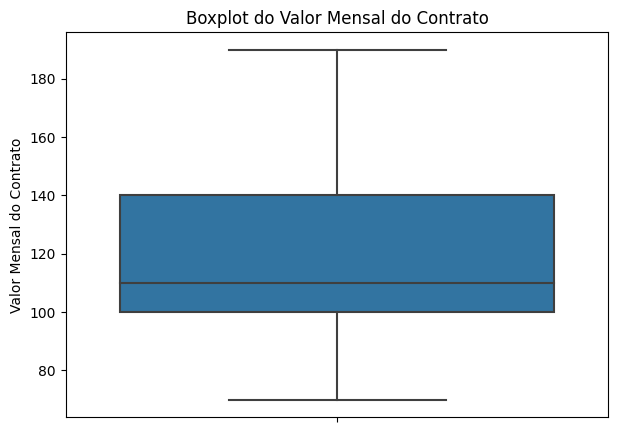

In [10]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=df, y='Valor Mensal do Contrato')
plt.title('Boxplot do Valor Mensal do Contrato')
plt.show()

Pelo gráfico acima, é possível observar que a maioria dos contratos possuem altos valores de manutenção - acima de 100 reais.

Agora, iremos analisar a quantidade de contratos por tipo de serviço.

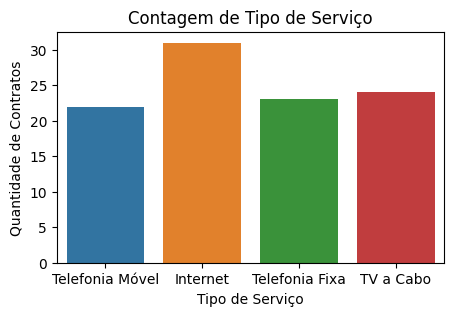

In [11]:
plt.figure(figsize=(5, 3))
sns.countplot(data=df, x='Tipo de Serviço')
plt.title('Contagem de Tipo de Serviço')
plt.ylabel('Quantidade de Contratos')
plt.show()

Como mostra o gráfico acima, há uma distribuição semelhante na quantidade de contratos por cada tipo de serviço, sendo o serviço mais contratado o de Internet (mais de 30% dos clientes).

Agora, partimos para a análise de perfil dos contratos.

#### Parte 1.2: análise dos contratos

Primeiramente, vamos analisar a quantidade total de reclamações por Tipo de Serviço.

In [12]:
grouped_data = df.groupby('Tipo de Serviço')['Número de Reclamações'].sum()
print(grouped_data)

Tipo de Serviço
Internet           6.0
TV a Cabo          8.0
Telefonia Fixa     0.0
Telefonia Móvel    4.0
Name: Número de Reclamações, dtype: float64


Como é possível observar, os serviços de Internet e TV a Cabo apresentam parte significativa das reclamações - 14 das 18 apresentadas no conjunto de dados.

Agora, vamos analisar as características dos contratos que foram cancelados.

In [13]:
df_tempo_ctt = df.copy()
df_tempo_ctt = df_tempo_ctt.query("`Data de Término do Contrato` != 0")
df_tempo_ctt['Data de Início do Contrato'] = pd.to_datetime(df_tempo_ctt['Data de Início do Contrato'])
df_tempo_ctt['Data de Término do Contrato'] = pd.to_datetime(df_tempo_ctt['Data de Término do Contrato'])


In [14]:
df_tempo_ctt["ID"].count()

4

Como é possível observar, somente 4% dos contratos foram cancelados. Agora, vamos traçar o perfil desses cancelamentos.

In [15]:
df_tempo_ctt["Tipo de Serviço"].value_counts()

TV a Cabo    3
Internet     1
Name: Tipo de Serviço, dtype: int64

Os serviços cancelados foram relativos a TV a Cabo e Internet, mais especificamente o primeiro. Agora, vejamos o preço médio desses serviços.

In [16]:
media_por_tipo_servico = df_tempo_ctt.groupby('Tipo de Serviço')['Valor Mensal do Contrato'].mean()
media_por_tipo_servico

Tipo de Serviço
Internet     139.99
TV a Cabo    129.99
Name: Valor Mensal do Contrato, dtype: float64

Como vimos no boxplot do valor mensal de contrato, essa média de valores faz parte do grupo com os valores mais caros de plano de serviços.

Vejamos o número de reclamações por tipo de serviço.

In [17]:
num_reclamacoes = df_tempo_ctt.groupby('Tipo de Serviço')['Número de Reclamações'].sum()
num_reclamacoes

Tipo de Serviço
Internet     1.0
TV a Cabo    0.0
Name: Número de Reclamações, dtype: float64

Como vimos acima, os clientes de TV a Cabo que cancelaram os serviços não apresentaram nenhuma reclamação.

Agora, vejamos o tempo de associação, em meses, dos contratos cancelados.

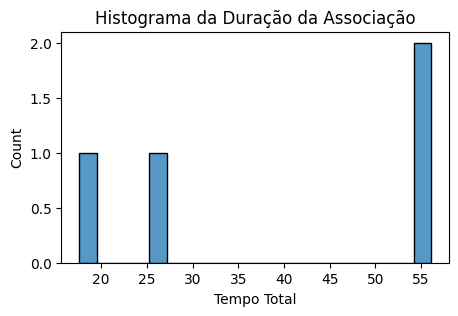

In [18]:
df_tempo_ctt['Tempo Total'] = df_tempo_ctt['Data de Término do Contrato'] - df_tempo_ctt['Data de Início do Contrato']
df_tempo_ctt['Tempo Total'] = df_tempo_ctt['Tempo Total'].dt.days / 30
plt.figure(figsize=(5, 3))
sns.histplot(data=df_tempo_ctt, x='Tempo Total', bins=20)
plt.title('Histograma da Duração da Associação')
plt.show()

No gráfico, vemos que os contratos cancelados, em geral, possuem mais de 2 anos de associação.

#### Parte 1.3: análise das reclamações

Vamos realizar a análise macro das reclamações a partir de nuvens de palavras dos comentários. A partir dessas nuvens de palavras e as informações mostradas anteriormente, serão criadas hipóteses para o perfil de reclamações.

Primeiro, veremos a nuvem de palavras dos comentários em geral.

In [19]:
# criando uma lista única com todos os comentários
complaints = df['Comentários'].str.cat(sep=' ').lower()

# tokenizando os termos
words = word_tokenize(complaints)

# unidecode é utilizado para remover pontuação, para que a nuvem de palavras não considere palavras
# escritas com pontuação e sem pontuação como palavras diferentes, modificando o peso de cada termo
filtered_words = [unidecode(word) for word in words if word.isalnum() and word not in stop_words]

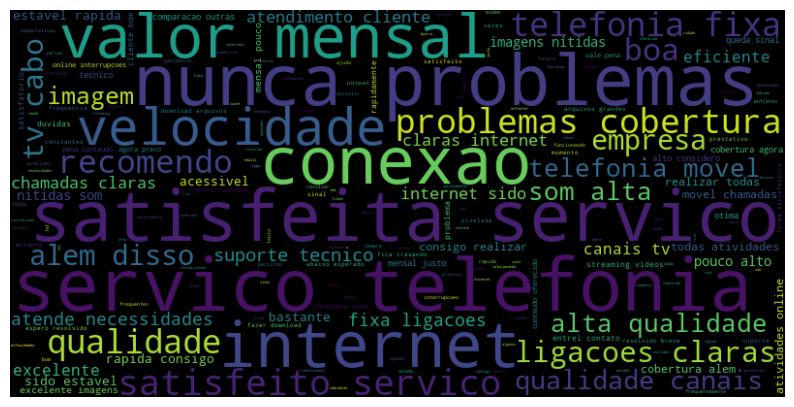

In [20]:
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(filtered_words))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.show()

Agora vamos ver a nuvem de palavras dos clientes que registraram no mínimo uma reclamação.

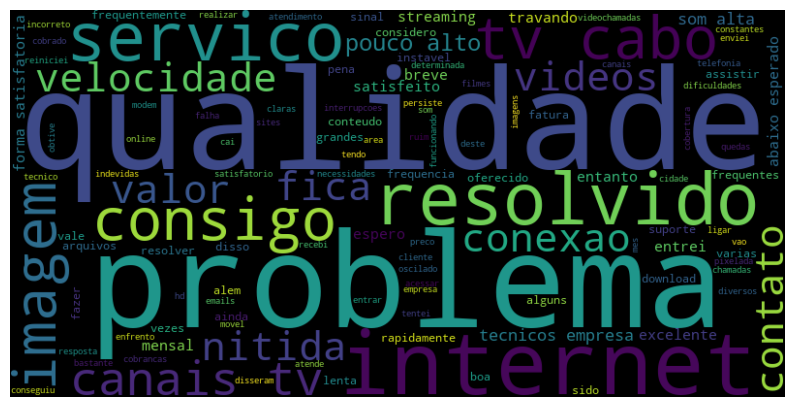

In [21]:
df['Número de Reclamações'] = pd.to_numeric(df['Número de Reclamações'], errors='coerce')
df_rec = df.copy()
df_rec = df_rec[df_rec['Número de Reclamações']>0]
complaints2 = df_rec['Comentários'].str.cat(sep=' ').lower()
words2 = word_tokenize(complaints2)
filtered_words2 = [unidecode(word) for word in words2 if word.isalnum() and word not in stop_words]

wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(filtered_words2))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.show()

Agora, veremos a nuvem de palavras cujo clientes não registraram reclamações.

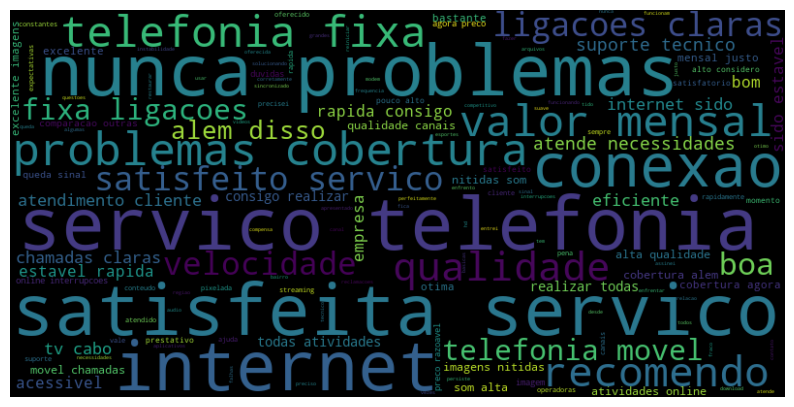

In [22]:
df_no_rec = df.copy()
df_no_rec = df_no_rec[df_no_rec['Número de Reclamações']==0]
complaints3 = df_no_rec['Comentários'].str.cat(sep=' ').lower()
words3 = word_tokenize(complaints3)
filtered_words3 = [unidecode(word) for word in words3 if word.isalnum() and word not in stop_words]

wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(filtered_words3))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.show()

A partir das nuvens de palavras, podemos inferir que os termos de impacto para a nuvem de palavras de reclamações foram:
- internet
- qualidade
- conexão
- tv a cabo
- canais de tv

Esses termos foram inferidos porque apareceram como termos importantes na nuvem de palavras de reclamações, mas não apareceram como termos de tanta relevância na de não-reclamações.
Utilizando essa mesma lógica, podemos ver que o termo internet tem relevância na nuvem de comentários gerais, e termos relacionados a telefonia têm relevância tanto na nuvem de comentários gerais quanto de não-reclamações.

### Parte 2: Hipóteses iniciais

A partir das seções anteriores, criamos as seguinte hipóteses:

- uma parcela significativa de comentários de clientes do tipo de serviço Internet e TV a Cabo tem teor negativo, mais especificamente o de Internet;
- a maioria das reclamações sobre TV a Cabo são relacionadas a canais de TV;
- a maioria das reclamações sobre internet são relacionadas à qualidade de conexão;
- a maioria dos comentários relacionados a telefonia fixa apresentam satisfação ou neutralidade;
- o cancelamento dos contratos de TV a Cabo se dão por questões relacionadas ao preço do pacote e qualidade dos canais de TV.

#### Parte 2.1: prova de hipóteses

Neste tópico, as seguintes hipóteses serão testadas:
1. uma parcela significativa de comentários de clientes do tipo de serviço Internet e TV a Cabo tem teor negativo, mais especificamente o de Internet;
2. a maioria dos comentários relacionados a telefonia fixa apresentam satisfação ou neutralidade.

Para isso, utilizaremos um algoritmo simples de análise de sentimentos para detectar a polaridade dos comentários.

In [23]:
# inicializando o lematizador
lemmatizer = WordNetLemmatizer()

# função de pré-processamento
def preprocess_text(text):
    words = nltk.word_tokenize(text)
    # remover pontuação
    words = [word.lower() for word in words if word.isalpha()]
    # remover stopwords  
    words = [word for word in words if word not in stop_words]
    # tratar negações
    words = mark_negation(words)  
    # lematizar
    words = [unidecode(lemmatizer.lemmatize(word)) for word in words]  
    return ' '.join(words)


In [24]:
# aplica o pré-processamento à coluna 'Comentários'
df['Comentários_Preprocessados'] = df['Comentários'].apply(preprocess_text)

df[['Comentários', 'Comentários_Preprocessados']].head()

,Comentários,Comentários_Preprocessados
0,O serviço de internet tem sido instável. Estou...,servico internet sido instavel tendo dificulda...
1,Estou satisfeita com o serviço. A velocidade d...,satisfeita servico velocidade internet otima s...
2,Tive problemas com a fatura deste mês. O valor...,problemas fatura deste mes valor cobrado incor...
3,Sem reclamações até o momento. O serviço tem a...,reclamacoes momento servico atendido expectati...
4,O canal de esportes não está funcionando corre...,canal esportes funcionando corretamente imagem...


In [25]:
sia = SentimentIntensityAnalyzer()

# função para analisar sentimentos
def analisar_sentimento_vader(texto):
    polaridade = sia.polarity_scores(texto)
    if polaridade['compound'] > 0.05:
        return 'Positivo'
    elif polaridade['compound'] < -0.05:
        return 'Negativo'
    else:
        return 'Neutro'


In [26]:
# aplicação da análise de sentimentos à coluna 'Comentários'
df['Sentimento'] = df['Comentários_Preprocessados'].apply(analisar_sentimento_vader)

df[['ID','Comentários', 'Sentimento']].head()

,ID,Comentários,Sentimento
0,1,O serviço de internet tem sido instável. Estou...,Neutro
1,2,Estou satisfeita com o serviço. A velocidade d...,Neutro
2,3,Tive problemas com a fatura deste mês. O valor...,Neutro
3,4,Sem reclamações até o momento. O serviço tem a...,Neutro
4,5,O canal de esportes não está funcionando corre...,Neutro


In [27]:
df['Sentimento'].value_counts()

Neutro      97
Positivo     3
Name: Sentimento, dtype: int64

Como visto acima, essa análise de sentimentos não ficou boa. Vamos tentar outra abordagem, com machine learning e poucos dados de treinamento.

In [28]:
df.loc[df['ID'] == 1, 'Sentimento'] = 'Negativo'
df.loc[df['ID'] == 2, 'Sentimento'] = 'Positivo'
df.loc[df['ID'] == 3, 'Sentimento'] = 'Negativo'
df.loc[df['ID'] == 4, 'Sentimento'] = 'Neutro'
df.loc[df['ID'] == 5, 'Sentimento'] = 'Negativo'

ids_para_atribuir = [1, 2, 3, 4, 5]
df_train = df[df['ID'].isin(ids_para_atribuir)]
df_train

,ID,Nome,Idade,Gênero,Localização,Estado Civil,Número de Dependentes,Data de Início do Contrato,Data de Término do Contrato,Valor Mensal do Contrato,Tipo de Serviço,Duração Média das Chamadas,Volume de Dados,Número de Reclamações,Comentários,Comentários_Preprocessados,Sentimento
0,1,João Silva,35,Masculino,São Paulo/SP/São Paulo,Casado,2,2018-05-10,0,79.99,Telefonia Móvel,4.5,2.3 GB,2.0,O serviço de internet tem sido instável. Estou...,servico internet sido instavel tendo dificulda...,Negativo
1,2,Maria Santos,28,Feminino,Rio de Janeiro/RJ/Rio de Janeiro,Solteiro,0,2019-03-15,0,109.99,Internet,0.0,0,0.0,Estou satisfeita com o serviço. A velocidade d...,satisfeita servico velocidade internet otima s...,Positivo
2,3,Carlos Oliveira,42,Masculino,Belo Horizonte/MG/Minas Gerais,Casado,1,2020-01-20,2021-06-30,139.99,Internet,0.0,0,1.0,Tive problemas com a fatura deste mês. O valor...,problemas fatura deste mes valor cobrado incor...,Negativo
3,4,Ana Pereira,55,Feminino,Porto Alegre/RS/Rio Grande do Sul,Viúvo,0,2017-09-01,0,159.99,Telefonia Fixa,6.2,0,0.0,Sem reclamações até o momento. O serviço tem a...,reclamacoes momento servico atendido expectati...,Neutro
4,5,Paulo Rodrigues,41,Masculino,Brasília/DF,Divorciado,3,2019-11-12,2022-01-05,99.99,TV a Cabo,0.0,0,0.0,O canal de esportes não está funcionando corre...,canal esportes funcionando corretamente imagem...,Negativo


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(df_train['Comentários_Preprocessados'], df_train['Comentários_Preprocessados'], test_size=0.3, random_state=42)

vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

model = MultinomialNB()
model.fit(X_train_vec, y_train)

predictions = model.predict(X_test_vec)

accuracy = accuracy_score(y_test, predictions)
print("Precisão do Modelo:", accuracy)


Precisão do Modelo: 0.0


Como é possível observar, o modelo não possui precisão alguma em sua execução, ou seja, é necessário mais dados de treinamento para sua execução. Para este tipo de modelo, é necessário que exista uma base considerável de dados rotulados, o que não é possível pelo tamanho total do conjunto de dados. Tentemos através de clusterização.

C:\Users\uni30187\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


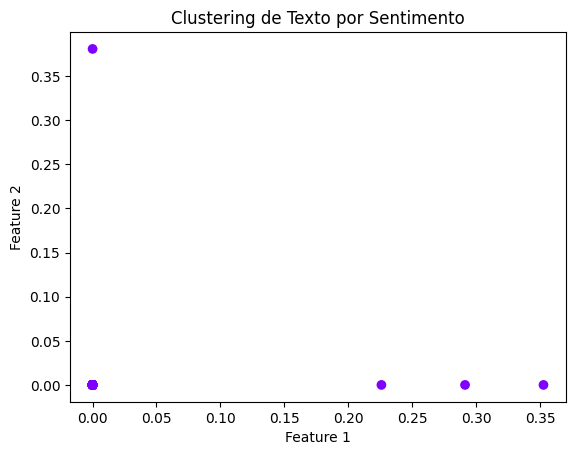

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df['Comentários_Preprocessados'])

# algoritmo K-means para clustering
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

plt.scatter(X.toarray()[:, 0], X.toarray()[:, 1], c=df['Cluster'], cmap='rainbow')
plt.title('Clustering de Texto por Sentimento')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


In [31]:
df['Cluster'].value_counts()

0    60
1    25
2    15
Name: Cluster, dtype: int64

In [32]:
df[df['Cluster']==0].head()

,ID,Nome,Idade,Gênero,Localização,Estado Civil,Número de Dependentes,Data de Início do Contrato,Data de Término do Contrato,Valor Mensal do Contrato,Tipo de Serviço,Duração Média das Chamadas,Volume de Dados,Número de Reclamações,Comentários,Comentários_Preprocessados,Sentimento,Cluster
0,1,João Silva,35,Masculino,São Paulo/SP/São Paulo,Casado,2,2018-05-10,0,79.99,Telefonia Móvel,4.5,2.3 GB,2.0,O serviço de internet tem sido instável. Estou...,servico internet sido instavel tendo dificulda...,Negativo,0
1,2,Maria Santos,28,Feminino,Rio de Janeiro/RJ/Rio de Janeiro,Solteiro,0,2019-03-15,0,109.99,Internet,0.0,0,0.0,Estou satisfeita com o serviço. A velocidade d...,satisfeita servico velocidade internet otima s...,Positivo,0
2,3,Carlos Oliveira,42,Masculino,Belo Horizonte/MG/Minas Gerais,Casado,1,2020-01-20,2021-06-30,139.99,Internet,0.0,0,1.0,Tive problemas com a fatura deste mês. O valor...,problemas fatura deste mes valor cobrado incor...,Negativo,0
4,5,Paulo Rodrigues,41,Masculino,Brasília/DF,Divorciado,3,2019-11-12,2022-01-05,99.99,TV a Cabo,0.0,0,0.0,O canal de esportes não está funcionando corre...,canal esportes funcionando corretamente imagem...,Negativo,0
5,1001,Renata Costa,32,Feminino,São Paulo/SP/São Paulo,Casado,1,2020-07-10,0,89.99,Telefonia Móvel,3.2,1.8 GB,0.0,O sinal de internet no meu bairro é muito frac...,sinal internet bairro fraco consigo usar aplic...,Neutro,0


In [33]:
df[df['Cluster']==1].head()

,ID,Nome,Idade,Gênero,Localização,Estado Civil,Número de Dependentes,Data de Início do Contrato,Data de Término do Contrato,Valor Mensal do Contrato,Tipo de Serviço,Duração Média das Chamadas,Volume de Dados,Número de Reclamações,Comentários,Comentários_Preprocessados,Sentimento,Cluster
3,4,Ana Pereira,55,Feminino,Porto Alegre/RS/Rio Grande do Sul,Viúvo,0,2017-09-01,0,159.99,Telefonia Fixa,6.2,0,0.0,Sem reclamações até o momento. O serviço tem a...,reclamacoes momento servico atendido expectati...,Neutro,1
9,1005,Amanda Lima,37,Feminino,Porto Alegre/RS/Rio Grande do Sul,Casado,2,2017-12-01,0,179.99,Telefonia Fixa,7.5,0,0.0,Estou satisfeita com o serviço de telefonia fi...,satisfeita servico telefonia fixa ligacoes cla...,Neutro,1
14,1010,Gustavo Pereira,48,Masculino,Porto Alegre/RS/Rio Grande do Sul,Divorciado,0,2019-02-01,0,159.99,Telefonia Fixa,4.8,0,0.0,O serviço de telefonia fixa tem sido satisfató...,servico telefonia fixa sido satisfatorio ligac...,Neutro,1
15,1011,Isabela Fernandes,27,Feminino,São Paulo/SP/São Paulo,Solteiro,0,2021-08-10,0,79.99,Telefonia Móvel,3.9,2.1 GB,0.0,Estou satisfeita com o serviço de telefonia mó...,satisfeita servico telefonia movel cobertura b...,Neutro,1
19,1015,Beatriz Oliveira,37,Feminino,Porto Alegre/RS/Rio Grande do Sul,Casado,2,2018-01-10,0,179.99,Telefonia Fixa,5.2,0,0.0,Estou muito satisfeita com o serviço de telefo...,satisfeita servico telefonia fixa ligacoes cla...,Neutro,1


In [34]:
df[df['Cluster']==2].head()

,ID,Nome,Idade,Gênero,Localização,Estado Civil,Número de Dependentes,Data de Início do Contrato,Data de Término do Contrato,Valor Mensal do Contrato,Tipo de Serviço,Duração Média das Chamadas,Volume de Dados,Número de Reclamações,Comentários,Comentários_Preprocessados,Sentimento,Cluster
7,1003,Luiza Rodrigues,39,Feminino,Belo Horizonte/MG/Minas Gerais,Casado,2,2018-02-20,2022-09-30,149.99,TV a Cabo,0.0,0,0.0,Os canais HD têm apresentado problemas de qual...,canais hd tem apresentado problemas qualidade ...,Neutro,2
12,1008,Rafael Mendes,29,Masculino,Rio de Janeiro/RJ/Rio de Janeiro,Solteiro,0,2018-09-15,0,129.99,TV a Cabo,0.0,0,2.0,O sinal da TV a cabo tem oscilado bastante. Al...,sinal tv cabo oscilado bastante alguns canais ...,Neutro,2
17,1013,Patrícia Costa,40,Feminino,Belo Horizonte/MG/Minas Gerais,Divorciado,1,2019-03-20,2023-09-30,139.99,TV a Cabo,0.0,0,0.0,A qualidade de imagem da TV a cabo é excelente...,qualidade imagem tv cabo excelente todos canai...,Neutro,2
24,1020,Felipe Santos,35,Masculino,Rio de Janeiro/RJ/Rio de Janeiro,Casado,2,2018-09-20,0,139.99,TV a Cabo,0.0,0,0.0,A qualidade dos canais de TV a cabo é excelent...,qualidade canais tv cabo excelente imagens nit...,Neutro,2
31,1029,Isabela Santos,33,Feminino,São Paulo/SP/São Paulo,Casado,1,2017-11-01,0,159.99,TV a Cabo,0.0,0,1.0,"A qualidade dos canais de TV é excelente, mas ...",qualidade canais tv excelente preco servico po...,Positivo,2


Pelo observado através dessa clusterização, os clusters possuem os seguintes rótulos:
- 0: comentários negativos
- 1: comentários positivos
- 2: comentários neutros

Agora vamos contabilizar os tipos de serviço presentes em cada cluster.

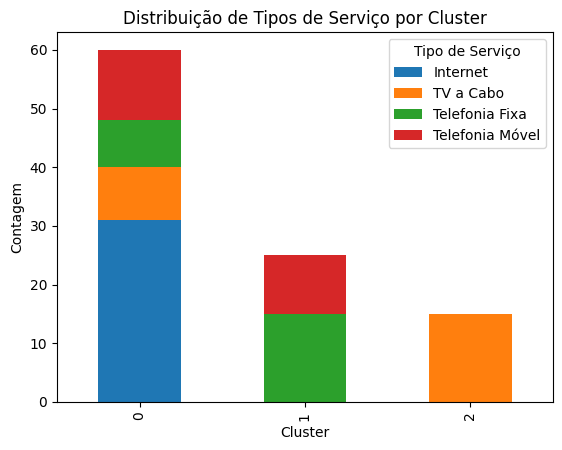

In [35]:
cluster_service_counts = df.groupby(['Cluster', 'Tipo de Serviço']).size().unstack(fill_value=0)
cluster_service_counts.plot(kind='bar', stacked=True)
plt.title('Distribuição de Tipos de Serviço por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Contagem')
plt.legend(title='Tipo de Serviço')
plt.show()

As seguinte hipóteses foram confirmadas:
1. A maior parte dos comentários negativos é relativo ao serviço de Internet.
2. A telefonia fixa possui comentários positivos em sua maioria.

Quanto à TV a Cabo, os comentários foram ou negativos ou neutros (considera-se aqui comentários que possuem elogos e reclamações no mesmo conteúdo).
Quanto à Telefonia móvel, os comentários oscilam numa distribuição quase homogênea entre positivo e negativo.

#### Parte 2.2: próximos passos

Para os próximos passos, as hipóteses abaixo serão trabalhadas:
1. a maioria das reclamações sobre TV a Cabo são relacionadas a canais de TV;
2. a maioria das reclamações sobre internet são relacionadas à qualidade de conexão;
3. o cancelamento dos contratos de TV a Cabo se dão por questões relacionadas ao preço do pacote e qualidade dos canais de TV.

Para as hipóteses (1) e (2), serão aplicados algoritmos de clusterização (K-Means) para encontrar os clusters de reclamação por assunto ou análise por palavra-chave, dependendo do desempenho de cada modelo.

Já para a hipótese (3), será feita uma análise de perfil de usuário, incluindo perfil sócio-econômico (caso a empresa forneça mais dados sobre os clientes), para inferir o impacto do preço dos pacotes de serviços no nível de reclamações e cancelamento de contrato. Essa análise será feita por meio de correlação, e será feito o cruzamento desses dados com os clusteres obtidos anteriormente.

Após finalizar todos os testes de hipóteses propostos, será proposto um algoritmo de recomendação que identifica potenciais clientes que afetam a taxa de churn, que será implementado utilizando as regras extraídas das hipóteses provadas.